In [2]:
%matplotlib inline

### DAISY local image descriptor
- based on gradient orientation histograms, similar to SIFT.
- designed for fast dense extraction

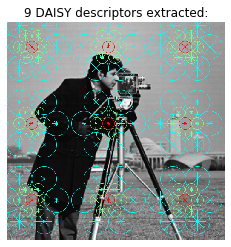

In [3]:
from skimage.feature import daisy
from skimage import data
import matplotlib.pyplot as plt


img = data.camera()
descs, descs_img = daisy(img, step=180, radius=58, rings=2, histograms=6,
                         orientations=8, visualize=True)

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()

### histogram of oriented gradients (HOG)

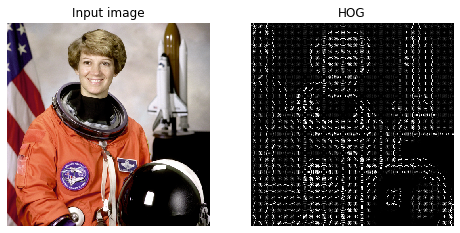

In [4]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG')
plt.show()

### template matching
- used to identify an image patch
- below: return single match (same coin),
- so max value in _match_template_ corresponds to its location

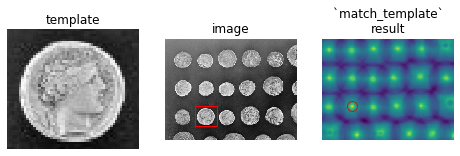

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import match_template


image = data.coins()
coin = image[170:220, 75:130]

result = match_template(image, coin)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(coin, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(image, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

### [corner detection](https://en.wikipedia.org/wiki/Corner_detection)
- uses Harris corner detector; determines subpixel position.
- [interest point detection](https://en.wikipedia.org/wiki/Interest_point_detection)

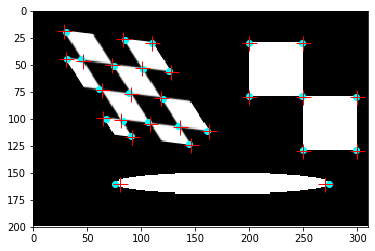

In [6]:
from matplotlib import pyplot as plt

from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse

# Sheared checkerboard
tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
                        translation=(110, 30))
image = warp(data.checkerboard()[:90, :90], tform.inverse,
             output_shape=(200, 310))
# Ellipse
rr, cc = ellipse(160, 175, 10, 100)
image[rr, cc] = 1
# Two squares
image[30:80, 200:250] = 1
image[80:130, 250:300] = 1

coords = corner_peaks(corner_harris(image), min_distance=5)
coords_subpix = corner_subpix(image, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 310, 200, 0))
plt.show()

### filling holes; finding peaks

In [7]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.exposure import rescale_intensity

image = data.moon()
# Rescale image intensity so that we can see dim features.
image = rescale_intensity(image, in_range=(50, 200))

In [8]:
# create seed image
import numpy as np
from skimage.morphology import reconstruction

seed = np.copy(image)
seed[1:-1, 1:-1] = image.max()
mask = image

filled = reconstruction(seed, mask, method='erosion')

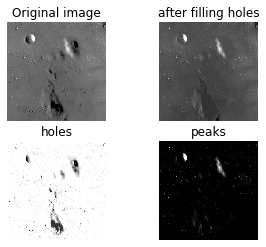

In [9]:
seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
rec = reconstruction(seed, mask, method='dilation')

fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(filled, cmap='gray')
ax[1].set_title('after filling holes')
ax[1].axis('off')

ax[2].imshow(image-filled, cmap='gray')
ax[2].set_title('holes')
ax[2].axis('off')

ax[3].imshow(image-rec, cmap='gray')
ax[3].set_title('peaks')
ax[3].axis('off')
plt.show()


### CENSURE feature detector
- scale-invariant, center-surround detector

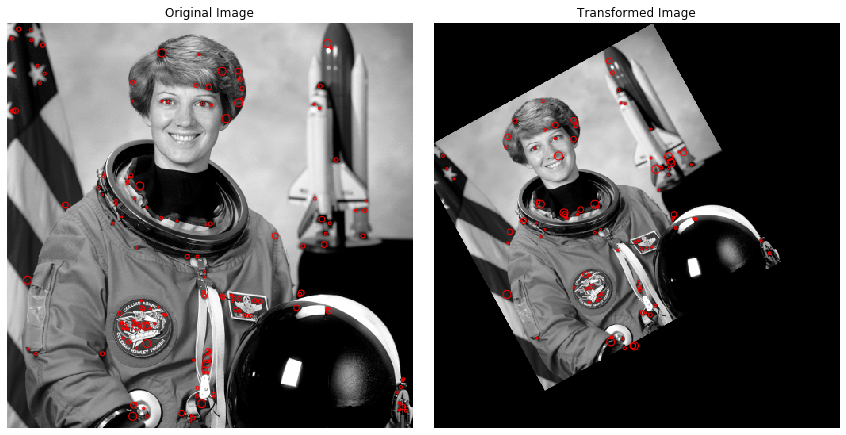

In [10]:
from skimage import data
from skimage import transform as tf
from skimage.feature import CENSURE
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


img_orig = rgb2gray(data.astronaut())
tform = tf.AffineTransform(scale=(1.5, 1.5), rotation=0.5,
                           translation=(150, -200))
img_warp = tf.warp(img_orig, tform)

detector = CENSURE()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

detector.detect(img_orig)

ax[0].imshow(img_orig, cmap=plt.cm.gray)
ax[0].scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')
ax[0].set_title("Original Image")

detector.detect(img_warp)

ax[1].imshow(img_warp, cmap=plt.cm.gray)
ax[1].scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')
ax[1].set_title('Transformed Image')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

### multiblock local binary pattern for texture classification

In [11]:
# generate 9x9 rectange image; subdivide it into 3x3
from skimage.feature import multiblock_lbp
import numpy as np
from numpy.testing import assert_equal
from skimage.transform import integral_image

# Create test matrix where first and fifth rectangles starting
# from top left clockwise have greater value than the central one.
test_img = np.zeros((9, 9), dtype='uint8')
test_img[3:6, 3:6] = 1
test_img[:3, :3] = 50
test_img[6:, 6:] = 50

# First and fifth bits should be filled. This correct value will
#  be compared to the computed one.
correct_answer = 0b10001000

int_img = integral_image(test_img)

lbp_code = multiblock_lbp(int_img, 0, 0, 3, 3)

assert_equal(correct_answer, lbp_code)

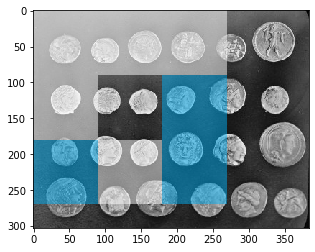

In [12]:
# apply operator to a real image
from skimage import data
from matplotlib import pyplot as plt
from skimage.feature import draw_multiblock_lbp

test_img = data.coins()
int_img  = integral_image(test_img)
lbp_code = multiblock_lbp(int_img, 0, 0, 90, 90)

img = draw_multiblock_lbp(test_img, 0, 0, 90, 90,
                          lbp_code=lbp_code, alpha=0.5)
plt.imshow(img)
plt.show()

### haar-like feature descriptors
- simple digital image features

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

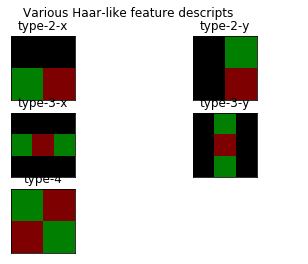

In [14]:
images = [np.zeros((2, 2)), np.zeros((2, 2)),
          np.zeros((3, 3)), np.zeros((3, 3)),
          np.zeros((2, 2))]

feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

fig, axs = plt.subplots(3, 2)
for ax, img, feat_t in zip(np.ravel(axs), images, feature_types):
    coord, _ = haar_like_feature_coord(img.shape[0], img.shape[1], feat_t)
    haar_feature = draw_haar_like_feature(img, 0, 0,
                                          img.shape[0],
                                          img.shape[1],
                                          coord,
                                          max_n_features=1,
                                          random_state=0)
    ax.imshow(haar_feature)
    ax.set_title(feat_t)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Various Haar-like feature descripts')
plt.axis('off')
plt.show()

### blob detection
- bright-on-dark, or dark-on-bright, image regions.
- using Hubble eXtreme Deep Field image.
- three algos demonstrated

/home/bjpcjp/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/bjpcjp/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/bjpcjp/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/bjpcjp/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


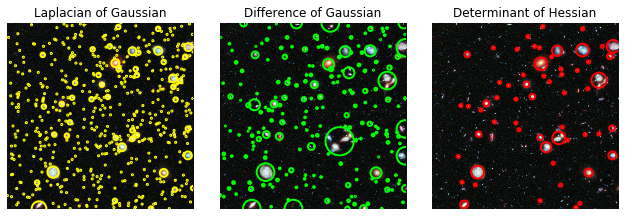

In [15]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()


### ORB feature detector / binary descriptor

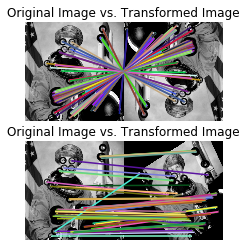

In [16]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


img1 = rgb2gray(data.astronaut())
img2 = tf.rotate(img1, 180)
tform = tf.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                           translation=(0, -200))
img3 = tf.warp(img1, tform)

descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
ax[1].axis('off')
ax[1].set_title("Original Image vs. Transformed Image")

plt.show()

### BRIEF binary descriptor

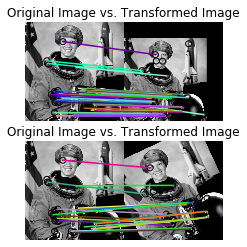

In [17]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


img1 = rgb2gray(data.astronaut())
tform = tf.AffineTransform(scale=(1.2, 1.2), translation=(0, -100))
img2 = tf.warp(img1, tform)
img3 = tf.rotate(img1, 25)

keypoints1 = corner_peaks(corner_harris(img1), min_distance=5)
keypoints2 = corner_peaks(corner_harris(img2), min_distance=5)
keypoints3 = corner_peaks(corner_harris(img3), min_distance=5)

extractor = BRIEF()

extractor.extract(img1, keypoints1)
keypoints1 = keypoints1[extractor.mask]
descriptors1 = extractor.descriptors

extractor.extract(img2, keypoints2)
keypoints2 = keypoints2[extractor.mask]
descriptors2 = extractor.descriptors

extractor.extract(img3, keypoints3)
keypoints3 = keypoints3[extractor.mask]
descriptors3 = extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
ax[1].axis('off')
ax[1].set_title("Original Image vs. Transformed Image")

plt.show()

### gabors / primary visual cortex "simple cells"

/home/bjpcjp/.local/lib/python3.6/site-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


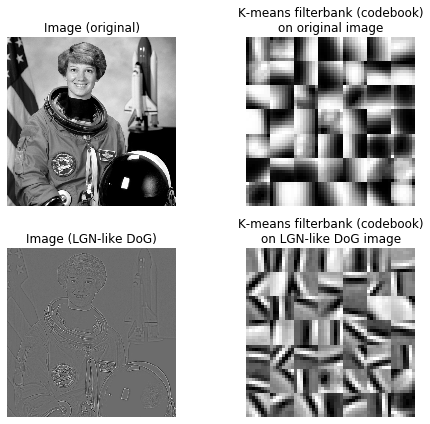

In [18]:
import numpy as np
from scipy.cluster.vq import kmeans2
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage.util.shape import view_as_windows
from skimage.util import montage

np.random.seed(42)

patch_shape = 8, 8
n_filters = 49

astro = color.rgb2gray(data.astronaut())

# -- filterbank1 on original image
patches1 = view_as_windows(astro, patch_shape)
patches1 = patches1.reshape(-1, patch_shape[0] * patch_shape[1])[::8]
fb1, _ = kmeans2(patches1, n_filters, minit='points')
fb1 = fb1.reshape((-1,) + patch_shape)
fb1_montage = montage(fb1, rescale_intensity=True)

# -- filterbank2 LGN-like image
astro_dog = ndi.gaussian_filter(astro, .5) - ndi.gaussian_filter(astro, 1)
patches2 = view_as_windows(astro_dog, patch_shape)
patches2 = patches2.reshape(-1, patch_shape[0] * patch_shape[1])[::8]
fb2, _ = kmeans2(patches2, n_filters, minit='points')
fb2 = fb2.reshape((-1,) + patch_shape)
fb2_montage = montage(fb2, rescale_intensity=True)

# -- plotting
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax = axes.ravel()

ax[0].imshow(astro, cmap=plt.cm.gray)
ax[0].set_title("Image (original)")

ax[1].imshow(fb1_montage, cmap=plt.cm.gray)
ax[1].set_title("K-means filterbank (codebook)\non original image")

ax[2].imshow(astro_dog, cmap=plt.cm.gray)
ax[2].set_title("Image (LGN-like DoG)")

ax[3].imshow(fb2_montage, cmap=plt.cm.gray)
ax[3].set_title("K-means filterbank (codebook)\non LGN-like DoG image")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()
plt.show()


### GLCM texture features

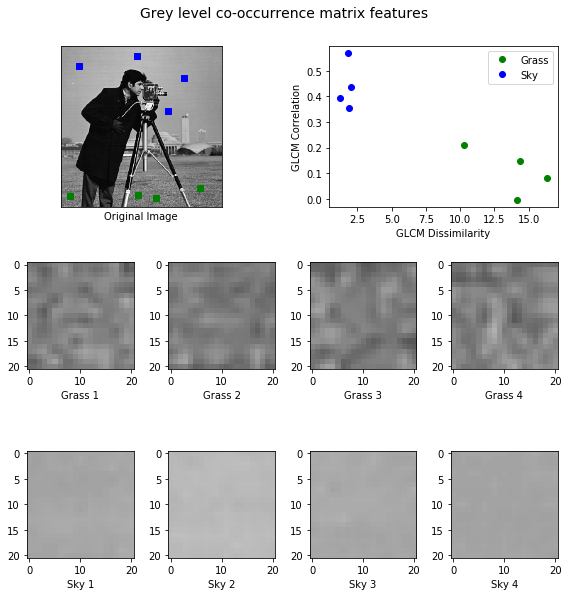

In [19]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data


PATCH_SIZE = 21

# open the camera image
image = data.camera()

# select some patches from grassy areas of the image
grass_locations = [(474, 291), (440, 433), (466, 18), (462, 236)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
sky_locations = [(54, 48), (21, 233), (90, 380), (195, 330)]
sky_patches = []
for loc in sky_locations:
    sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + sky_patches):
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in sky_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='Grass')
ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='Sky')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(grass_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Grass %d' % (i + 1))

for i, patch in enumerate(sky_patches):
    ax = fig.add_subplot(3, len(sky_patches), len(sky_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Sky %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


### shape index

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage as ndi
from skimage.feature import shape_index
from skimage.draw import disk


def create_test_image(
        image_size=256, spot_count=30, spot_radius=5, cloud_noise_size=4):
    """
    Generate a test image with random noise, uneven illumination and spots.
    """
    state = np.random.get_state()
    np.random.seed(314159265)  # some digits of pi

    image = np.random.normal(
        loc=0.25,
        scale=0.25,
        size=(image_size, image_size)
    )

    for _ in range(spot_count):
        rr, cc = disk(
            (np.random.randint(image.shape[0]),
             np.random.randint(image.shape[1])),
            spot_radius,
            shape=image.shape
        )
        image[rr, cc] = 1

    image *= np.random.normal(loc=1.0, scale=0.1, size=image.shape)

    image *= ndi.zoom(
        np.random.normal(
            loc=1.0,
            scale=0.5,
            size=(cloud_noise_size, cloud_noise_size)
        ),
        image_size / cloud_noise_size
    )

    np.random.set_state(state)

    return ndi.gaussian_filter(image, sigma=2.0)

# First create the test image and its shape index

image = create_test_image()

s = shape_index(image)

# In this example we want to detect 'spherical caps',
# so we threshold the shape index map to
# find points which are 'spherical caps' (~1)

target = 1
delta = 0.05

point_y, point_x = np.where(np.abs(s - target) < delta)
point_z = image[point_y, point_x]

# The shape index map relentlessly produces the shape, even that of noise.
# In order to reduce the impact of noise, we apply a Gaussian filter to it,
# and show the results once in

s_smooth = ndi.gaussian_filter(s, sigma=0.5)

point_y_s, point_x_s = np.where(np.abs(s_smooth - target) < delta)
point_z_s = image[point_y_s, point_x_s]


fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)

ax1.imshow(image, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Input image')

scatter_settings = dict(alpha=0.75, s=10, linewidths=0)

ax1.scatter(point_x, point_y, color='blue', **scatter_settings)
ax1.scatter(point_x_s, point_y_s, color='green', **scatter_settings)

ax2 = fig.add_subplot(1, 3, 2, projection='3d', sharex=ax1, sharey=ax1)

x, y = np.meshgrid(
    np.arange(0, image.shape[0], 1),
    np.arange(0, image.shape[1], 1)
)

ax2.plot_surface(x, y, image, linewidth=0, alpha=0.5)

ax2.scatter(
    point_x,
    point_y,
    point_z,
    color='blue',
    label='$|s - 1|<0.05$',
    **scatter_settings
)

ax2.scatter(
    point_x_s,
    point_y_s,
    point_z_s,
    color='green',
    label='$|s\' - 1|<0.05$',
    **scatter_settings
)

ax2.legend(loc='lower left')

ax2.axis('off')
ax2.set_title('3D visualization')

ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)

ax3.imshow(s, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Shape index, $\sigma=1$')

fig.tight_layout()

plt.show()


ImportError: cannot import name 'disk'

### sliding window histogram

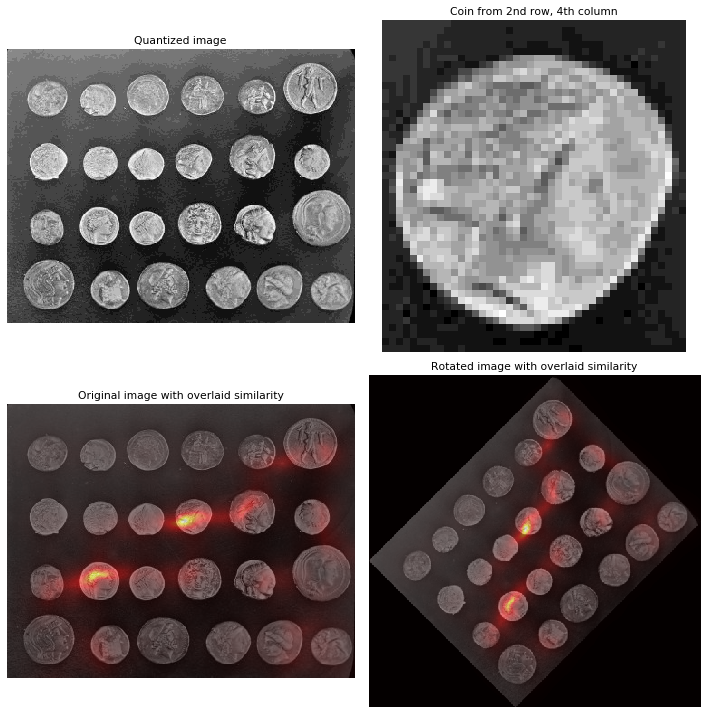

In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from skimage import data, transform
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from skimage.filters import rank


matplotlib.rcParams['font.size'] = 9


def windowed_histogram_similarity(image, selem, reference_hist, n_bins):
    # Compute normalized windowed histogram feature vector for each pixel
    px_histograms = rank.windowed_histogram(image, selem, n_bins=n_bins)

    # Reshape coin histogram to (1,1,N) for broadcast when we want to use it in
    # arithmetic operations with the windowed histograms from the image
    reference_hist = reference_hist.reshape((1, 1) + reference_hist.shape)

    # Compute Chi squared distance metric: sum((X-Y)^2 / (X+Y));
    # a measure of distance between histograms
    X = px_histograms
    Y = reference_hist

    num = (X - Y) ** 2
    denom = X + Y
    denom[denom == 0] = np.infty
    frac = num / denom

    chi_sqr = 0.5 * np.sum(frac, axis=2)

    # Generate a similarity measure. It needs to be low when distance is high
    # and high when distance is low; taking the reciprocal will do this.
    # Chi squared will always be >= 0, add small value to prevent divide by 0.
    similarity = 1 / (chi_sqr + 1.0e-4)

    return similarity


# Load the `skimage.data.coins` image
img = img_as_ubyte(data.coins())

# Quantize to 16 levels of greyscale; this way the output image will have a
# 16-dimensional feature vector per pixel
quantized_img = img // 16

# Select the coin from the 4th column, second row.
# Co-ordinate ordering: [x1,y1,x2,y2]
coin_coords = [184, 100, 228, 148]   # 44 x 44 region
coin = quantized_img[coin_coords[1]:coin_coords[3],
                     coin_coords[0]:coin_coords[2]]

# Compute coin histogram and normalize
coin_hist, _ = np.histogram(coin.flatten(), bins=16, range=(0, 16))
coin_hist = coin_hist.astype(float) / np.sum(coin_hist)

# Compute a disk shaped mask that will define the shape of our sliding window
# Example coin is ~44px across, so make a disk 61px wide (2 * rad + 1) to be
# big enough for other coins too.
selem = disk(30)

# Compute the similarity across the complete image
similarity = windowed_histogram_similarity(quantized_img, selem, coin_hist,
                                           coin_hist.shape[0])

# Now try a rotated image
rotated_img = img_as_ubyte(transform.rotate(img, 45.0, resize=True))
# Quantize to 16 levels as before
quantized_rotated_image = rotated_img // 16
# Similarity on rotated image
rotated_similarity = windowed_histogram_similarity(quantized_rotated_image,
                                                   selem, coin_hist,
                                                   coin_hist.shape[0])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axes[0, 0].imshow(quantized_img, cmap='gray')
axes[0, 0].set_title('Quantized image')
axes[0, 0].axis('off')

axes[0, 1].imshow(coin, cmap='gray')
axes[0, 1].set_title('Coin from 2nd row, 4th column')
axes[0, 1].axis('off')

axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].imshow(similarity, cmap='hot', alpha=0.5)
axes[1, 0].set_title('Original image with overlaid similarity')
axes[1, 0].axis('off')

axes[1, 1].imshow(rotated_img, cmap='gray')
axes[1, 1].imshow(rotated_similarity, cmap='hot', alpha=0.5)
axes[1, 1].set_title('Rotated image with overlaid similarity')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


### gabor filter banks for texture classification

Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: brick


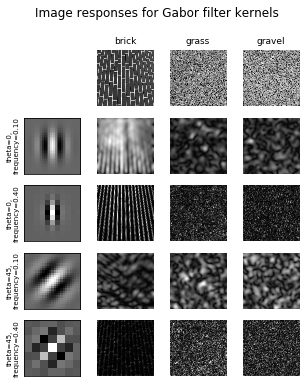

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


shrink = (slice(0, None, 3), slice(0, None, 3))
brick = img_as_float(data.brick())[shrink]
grass = img_as_float(data.grass())[shrink]
gravel = img_as_float(data.gravel())[shrink]
image_names = ('brick', 'grass', 'gravel')
images = (brick, grass, gravel)

# prepare reference features
ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(brick, kernels)
ref_feats[1, :, :] = compute_feats(grass, kernels)
ref_feats[2, :, :] = compute_feats(gravel, kernels)

print('Rotated images matched against references using Gabor filter banks:')

print('original: brick, rotated: 30deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=190, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: brick, rotated: 70deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: grass, rotated: 145deg, match result: ', end='')
feats = compute_feats(ndi.rotate(grass, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(5, 6))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()


### local binary pattern for texture classification

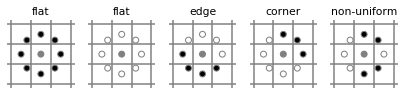

In [23]:
import numpy as np
import matplotlib.pyplot as plt


METHOD = 'uniform'
plt.rcParams['font.size'] = 9


def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)


def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(8),
                   np.ones(8),
                   np.hstack([np.ones(4), np.zeros(4)]),
                   np.hstack([np.zeros(3), np.ones(5)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)


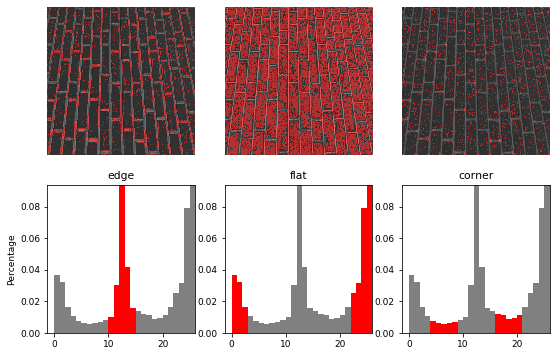

In [24]:
# apply LBP to a brick texture
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


image = data.brick()
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')


Rotated images matched against references using LBP:
original: brick, rotated: 30deg, match result:  brick
original: brick, rotated: 70deg, match result:  brick
original: grass, rotated: 145deg, match result:  grass


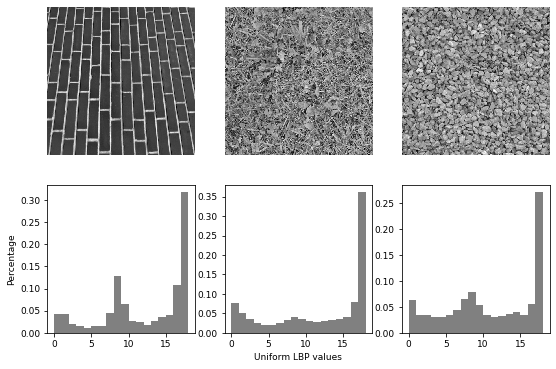

In [25]:
# test histrogram distributions against each other
# using kullback-leibler divergence

# settings for LBP
radius = 2
n_points = 8 * radius


def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


brick = data.brick()
grass = data.grass()
gravel = data.gravel()

refs = {
    'brick': local_binary_pattern(brick, n_points, radius, METHOD),
    'grass': local_binary_pattern(grass, n_points, radius, METHOD),
    'gravel': local_binary_pattern(gravel, n_points, radius, METHOD)
}

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: brick, rotated: 30deg, match result: ',
      match(refs, rotate(brick, angle=30, resize=False)))
print('original: brick, rotated: 70deg, match result: ',
      match(refs, rotate(brick, angle=70, resize=False)))
print('original: grass, rotated: 145deg, match result: ',
      match(refs, rotate(grass, angle=145, resize=False)))

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(9, 6))
plt.gray()

ax1.imshow(brick)
ax1.axis('off')
hist(ax4, refs['brick'])
ax4.set_ylabel('Percentage')

ax2.imshow(grass)
ax2.axis('off')
hist(ax5, refs['grass'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(gravel)
ax3.axis('off')
hist(ax6, refs['gravel'])

plt.show()
